# Example of a Convolutional Neural Network (12-Multiclass) for Text Classification

We first include all the necesary imports.

In [1]:
#Imports needed from pytorch
import torch
import torch.nn as nn

#Some built-in imports
import numpy as np
import matplotlib.pyplot as plt
import pickle
from os.path import join, isfile

#Imports from the repository
from data_processing import get_weight_matrix
from privacy_policies_dataset import PrivacyPoliciesDataset as PPD
from cnn import CNN

In [2]:
def confusion_matrix(model, dataset, label, threshold):
    
    metrics = {}
    x = PPD.collate_data(dataset)[0]
    y_hat = model(x)
    y_hat = torch.ge(y_hat, threshold).double()
    y = dataset.labels_tensor[:,label].unsqueeze(1).double() 
    tp = (y * y_hat).sum()
    tn = ((1 - y) * (1 - y_hat)).sum()
    fp = (y_hat * (1 - y)).sum()
    fn = ((1 - y_hat) * y).sum()
    metrics['TP{}'.format(label)] = tp
    metrics['TN{}'.format(label)] = tn
    metrics['FP{}'.format(label)] = fp
    metrics['FN{}'.format(label)] = fn
    
    return metrics

def save_confusion_matrix(matrix, label, name, output_path):
    
    output = join(output_path, 'cm{}_{}.pkl'.format(label, name))
    
    with open(output, 'wb') as f:
        
        pickle.dump(matrix, f)
        
def load_confusion_matrix(path, label):
    
    matrix_path = join(path, 'cm{}.pkl'.format(label))
    
    with open(matrix_path, 'rb') as f:
        
        return pickle.load(f)

In [3]:
def confusion_matrices(model, dataset, threshold):
    
    metrics = {}
    x = PPD.collate_data(dataset)[0]
    y_hat = model(x)
    y_hat = torch.ge(y_hat, threshold).double()
    y = dataset.labels_tensor.double() 
    tp = (y * y_hat).sum(0).numpy()
    tn = ((1 - y) * (1 - y_hat)).sum(0).numpy()
    fp = (y_hat * (1 - y)).sum(0).numpy()
    fn = ((1 - y_hat) * y).sum(0).numpy()
    metrics['TP'] = tp
    metrics['TN'] = tn
    metrics['FP'] = fp
    metrics['FN'] = fn
    
    return metrics

def confusion_matrices_change(metrics_05, metrics_best_t):
    
    labels = range(12)
    fig = plt.figure()
    fig.suptitle("metrics differences")
    tp_ax = fig.add_subplot(411)
    tn_ax = fig.add_subplot(412)
    fp_ax = fig.add_subplot(413)
    fn_ax = fig.add_subplot(414)
    
    tp_ax.plot(labels, metrics_05['TP'])
    tn_ax.plot(labels, metrics_05['TN'])
    fp_ax.plot(labels, metrics_05['FP'])
    fn_ax.plot(labels, metrics_05['FN'])
    
    tp_ax.plot(labels, metrics_05['TP'])
    tn_ax.plot(labels, metrics_05['TN'])
    fp_ax.plot(labels, metrics_05['FP'])
    fn_ax.plot(labels, metrics_05['FN'])
    
    plt.show()

In [4]:
def get_metrics_t(model, training_dataset, validation_dataset):
    
    threshold_list = np.arange(0.0, 1, 0.01)
    
    eps = 1e-10
    
    f1_scores = []
    
    precisions = []
    
    recalls = []
    
    for t in threshold_list:
        
        cm = confusion_matrix(model, validation_dataset, label, t)
        
        tp = cm['TP{}'.format(label)]
        
        fp = cm['FP{}'.format(label)]
        
        fn = cm['FN{}'.format(label)]
        
        f1 = 2 * tp / (2 * tp + fn + fp + eps)
        
        precision = tp / (tp + fp + eps)
        
        recall = tp / (tp + fn + eps)
        
        f1_scores.append(f1)
        
        precisions.append(precision)
        
        recalls.append(recalls)
        
    return f1_scores, precisions, recalls

In [5]:
def get_best_threshold(model, validation_dataset, label):
    
    eps = 1e-10
    
    threshold_list = np.arange(0.0, 1, 0.01)
    
    best_f1 = 0
    
    best_t = 0
    
    for t in threshold_list:
        
        cm = confusion_matrix(model, validation_dataset, label, t)
        
        tp = cm['TP{}'.format(label)]
        
        fp = cm['FP{}'.format(label)]
        
        fn = cm['FN{}'.format(label)]
        
        f1 = 2 * tp / (2 * tp + fn + fp + eps) 
        
        if f1 > best_f1:
            
            best_f1 = f1
            
            best_t = t
            
    return best_f1, best_t

## Data Loading

The first step is to load the previously split data into the three datasets: train, validation and text dataset.

In [6]:
test_dataset = PPD.unpickle_dataset("datasets/test_dataset_label6.pkl")

train_dataset = PPD.unpickle_dataset("datasets/train_dataset_label6.pkl")

validation_dataset = PPD.unpickle_dataset("datasets/validation_dataset_label6.pkl")

In [7]:
train_dataset.labels_stats()

Num of segments: 2274
Num of labels: 3886
Percentages with respect to number of segments ... 
0. First Party Collection/Use : 925 (40.68%)
1. Third Party Sharing/Collection : 692 (30.43%)
2. User Access, Edit and Deletion : 142 (6.24%)
3. Data Retention : 83 (3.65%)
4. Data Security : 218 (9.59%)
5. International and Specific Audiences : 216 (9.5%)
6. Do Not Track : 18 (0.79%)
7. Policy Change : 121 (5.32%)
8. User Choice/Control : 380 (16.71%)
9. Introductory/Generic : 499 (21.94%)
10. Practice not covered : 394 (17.33%)
11. Privacy contact information : 198 (8.71%)


We now load the weight matrix that will be used in the embedding layer. If the weight matrix hasn't been created yet we will need to use the data_processing.py to do so.

In [8]:
weights_matrix = get_weight_matrix(300, "embeddings_data/FastTextMatrices/NoOOV", read = True)

Loading from file weights_matrix_300.pkl


Now we take a look to all the labels and select one of them to be trained

In [9]:
labels = train_dataset.labels

for label, index in labels.items():
    
    print(str(index) + '. ' + label)

0. First Party Collection/Use
1. Third Party Sharing/Collection
2. User Access, Edit and Deletion
3. Data Retention
4. Data Security
5. International and Specific Audiences
6. Do Not Track
7. Policy Change
8. User Choice/Control
9. Introductory/Generic
10. Practice not covered
11. Privacy contact information


In [ ]:
label = int(raw_input("Insert label index: "))

for label_name, index in labels.items():
    
    if index == label:
        
        print(str(index) + '. ' + label_name)
        

## Training the CNN

The last step is to instatntiate a CNN with the desired parameters, load the embeddings and train the model.

In [ ]:
model = CNN(weights_matrix.shape[0], weights_matrix.shape[1], 200, [100], 1, [3], name = 'label{}_polisis'.format((label)))

model.load_pretrained_embeddings(weights_matrix)

In [ ]:
results = model.train_label(train_dataset, validation_dataset, label, epochs_num = 20, lr = 0.005, alpha = 0, momentum = 0.9)

epochs, train_losses, validation_losses = results

## Training all labels

Training label Data Security ... 
last epoch finished: 69 -- progress: 100% -- time: 1.63126803869 mins
Training completed. Total training time: 10.42 mins
218.0 Labels T
2274 Segments T
69.0 Labels V
757 Segments V


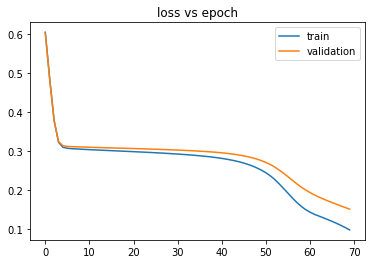

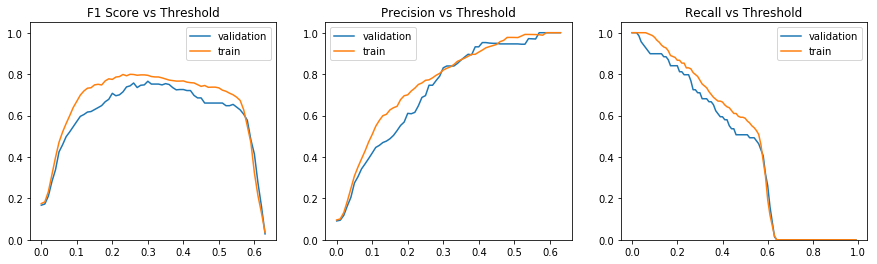

Scores with 0.5 threshold
---------------------------------------------------------------------------------------------------------
f1        |0.660377383232
precision |0.94594591856
recall    |0.507246375084
---------------------------------------------------------------------------------------------------------
label4 F1: 0.765624999999
Training label Do Not Track ... 
last epoch finished: 149 -- progress: 100% -- time: 1.57684288034 mins
Training completed. Total training time: 21.87 mins
18.0 Labels T
2274 Segments T
9.0 Labels V
757 Segments V


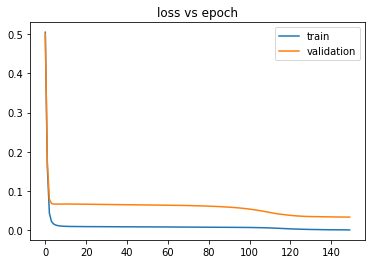

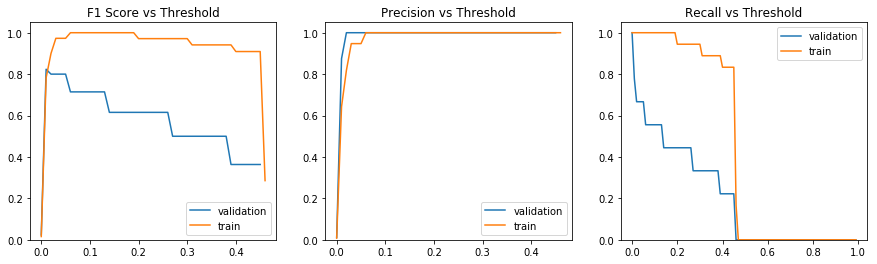

Scores with 0.5 threshold
---------------------------------------------------------------------------------------------------------
f1        |nan
precision |nan
recall    |0.0
---------------------------------------------------------------------------------------------------------
label6 F1: 0.82352941176
Training label User Choice/Control ... 
last epoch finished: 69 -- progress: 100% -- time: 1.48840043184 mins
Training completed. Total training time: 9.46 mins
380.0 Labels T
2274 Segments T
118.0 Labels V
757 Segments V


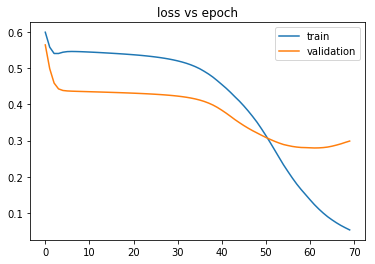

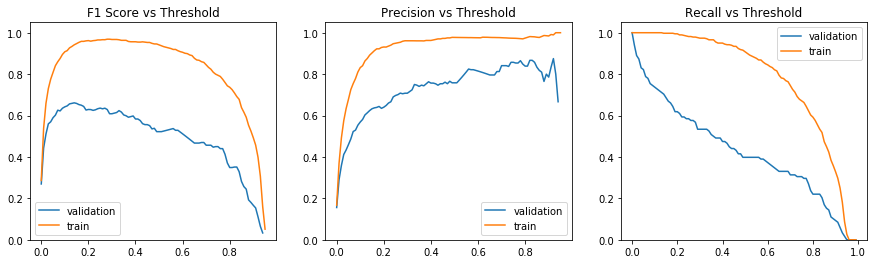

Scores with 0.5 threshold
---------------------------------------------------------------------------------------------------------
f1        |0.522222220898
precision |0.758064508438
recall    |0.398305088282
---------------------------------------------------------------------------------------------------------
label8 F1: 0.661354581673
Training label Introductory/Generic ... 
last epoch finished: 64 -- progress: 100% -- time: 11.972166834 mins
Training completed. Total training time: 102.29 mins
499.0 Labels T
2274 Segments T
153.0 Labels V
757 Segments V


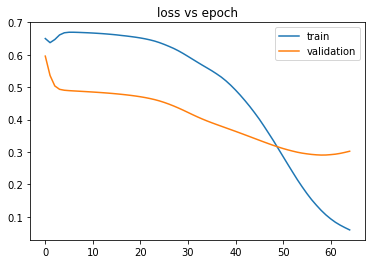

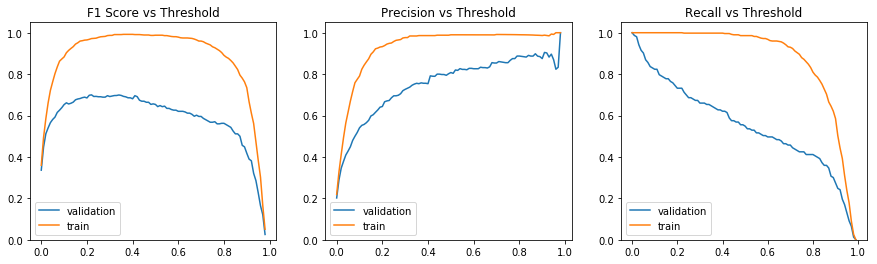

Scores with 0.5 threshold
---------------------------------------------------------------------------------------------------------
f1        |0.653696537018
precision |0.807692289352
recall    |0.549019634724
---------------------------------------------------------------------------------------------------------
label9 F1: 0.7
Training label Practice not covered ... 
last epoch finished: 79 -- progress: 100% -- time: 22.0095400707 mins
Training completed. Total training time: 120.95 mins
394.0 Labels T
2274 Segments T
118.0 Labels V
757 Segments V


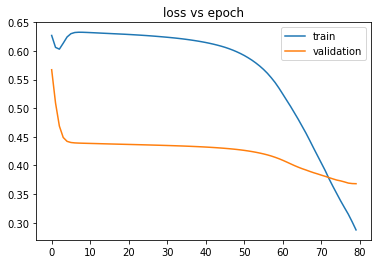

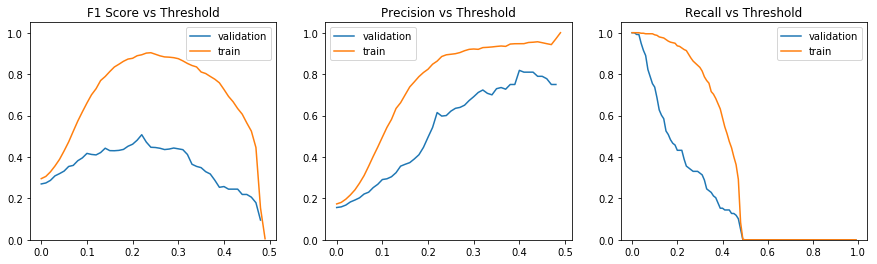

Scores with 0.5 threshold
---------------------------------------------------------------------------------------------------------
f1        |nan
precision |nan
recall    |0.0
---------------------------------------------------------------------------------------------------------
label10 F1: 0.507462686567
Training label Privacy contact information ... 
last epoch finished: 59 -- progress: 100% -- time: 1.48000513921 mins
Training completed. Total training time: 8.06 mins
198.0 Labels T
2274 Segments T
60.0 Labels V
757 Segments V


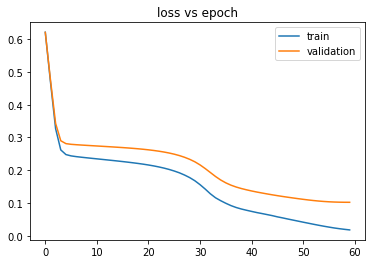

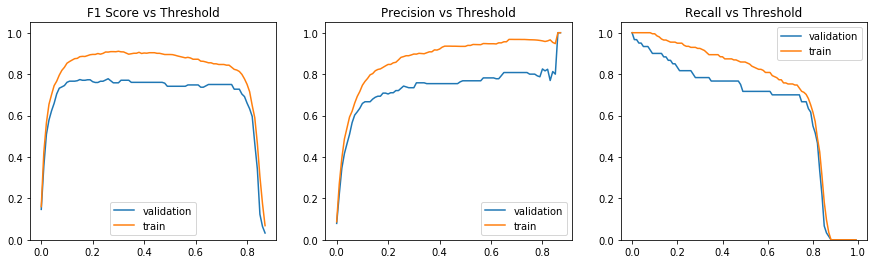

Scores with 0.5 threshold
---------------------------------------------------------------------------------------------------------
f1        |0.741379320621
precision |0.767857134342
recall    |0.716666638851
---------------------------------------------------------------------------------------------------------
label11 F1: 0.777777777777


In [11]:
epochs_num = [60, 60, 150, 150, 70, 100, 150, 100, 70, 65, 80, 60]

lr = 0.001

best_thresholds = []

for label in range(12):    
    
    if epochs_num[label] == 100 or label in [0,1,2,3]:
        
        continue
    
    model = CNN(weights_matrix.shape[0], weights_matrix.shape[1], 200, [100, 25], 1, [3], 
                name = 'e{}_label{}_polisis'.format(epochs_num[label],label))

    model.load_pretrained_embeddings(weights_matrix)

    results = model.train_label(train_dataset, validation_dataset, label, epochs_num = epochs_num[label], lr = lr, 
                                alpha = 0, momentum = 0.9)

    epochs, train_losses, validation_losses = results

    plt.plot(epochs, train_losses, label = "train")

    plt.plot(epochs, validation_losses, label = "validation")

    plt.legend()

    plt.title("loss vs epoch")

    plt.savefig(join("trained_models_pics/MulticlassOpt", model.cnn_name + '_loss.png'), format = 'png')

    dict_path = join("trained_models/MulticlassOpt", model.cnn_name + "_state.pt")

    torch.save(model.state_dict(), dict_path)

    model.save_cnn_params()

    model.print_results_label(train_dataset, validation_dataset, label, 0.5)
    
    cm_05 = confusion_matrix(model, validation_dataset, label, 0.5)

    save_confusion_matrix(cm_05, label, '0.5', 'trained_models/MulticlassOpt')
    
    best_f1, best_t = get_best_threshold(model, validation_dataset, label)
    
    print('label{} F1: {}'.format(label,best_f1))
    
    best_thresholds.append(best_t)
    
    cm_bt = confusion_matrix(model, validation_dataset, label, 0.5)

    save_confusion_matrix(cm_bt, label, 'best_t', 'trained_models/MulticlassOpt')
    
with open('trained_models/MulticlassOpt/best_thresholds.pkl','wb') as f:

    pickle.dump(best_thresholds, f)

## Results

This first block of code will show us the how the loss develops during the training.

In [ ]:
plt.plot(epochs, train_losses, label = "train")

plt.plot(epochs, validation_losses, label = "validation")

plt.legend()

plt.title("loss vs epoch")

plt.savefig(join("trained_models_pics", model.cnn_name + '_loss.png'), format = 'png')

plt.show()

We save the model so that we can use it further in the future.

In [ ]:
dict_path = join("trained_models", model.cnn_name + "_state.pt")

torch.save(model.state_dict(), dict_path)

model.save_cnn_params()

And finally, we print the metrics to evaluate the model.

In [ ]:
model.print_results_label(train_dataset, test_dataset, label, 0.5)

In [ ]:
cm = confusion_matrix(model, test_dataset, label, 0.6)

In [ ]:
save_confusion_matrix(cm, label, 'trained_models/Multiclass')